In [0]:
import numpy as np
import matplotlib.pyplot as plt 
import os

import time
import copy
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

from sklearn import decomposition
import scipy

In [0]:
!pip install torchviz
import torchviz

     |████████████████████████████████| 51kB 8.6MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3523 sha256=5a27a2e4b2de18df6fb627e7b5258f42307e1c243626cea0f52ddfb745b54158
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [0]:
#!mkdir /content/PythonCode
os.mkdir('/content/PythonCode')
os.chdir('/content/PythonCode/')
!git clone https://github.com/CIA-Oceanix/DinAE_4DVarNN_torch.git
os.chdir('/content/PythonCode/DinAE')
#!git pull
#import DinAE

Cloning into 'DinAE_4DVarNN_torch'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 53 (delta 21), reused 22 (delta 7), pack-reused 0
Unpacking objects: 100% (53/53), done.


FileNotFoundError: ignored

In [0]:
#os.mkdir('/content/PythonCode')
#os.chdir('/content/PythonCode')
#!git clone https://github.com/CIA-Oceanix/DinAE.git
os.chdir('/content/PythonCode/DinAE_4DVarNN_torch')
import torch_4DVarNN_dinAE as NN_4DVar

In [0]:
# mount gdrive
from google.colab import drive
drive.mount('/content/drive')

!ls /content/drive/My\ Drive/ResearchData/patchDataset_OcciputData.nc
import os
os.chdir('/content/drive/My Drive/')
!pwd

# L63 Data simulation

(20000, 3)


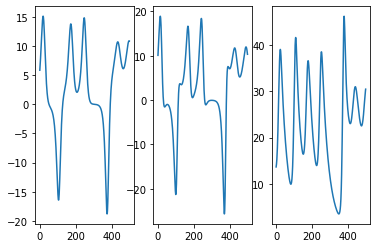

In [0]:
from scipy.integrate import solve_ivp

def AnDA_Lorenz_63(S,t,sigma,rho,beta):
    """ Lorenz-63 dynamical model. """
    x_1 = sigma*(S[1]-S[0]);
    x_2 = S[0]*(rho-S[2])-S[1];
    x_3 = S[0]*S[1] - beta*S[2];
    dS  = np.array([x_1,x_2,x_3]);
    return dS

class GD:
    model = 'Lorenz_63'
    class parameters:
        sigma = 10.0
        rho = 28.0
        beta = 8.0/3
    dt_integration = 0.01 # integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8 # number of integration times between consecutive observations (for yo)
    var_obs = np.array([0,1,2]) # indices of the observed variables
    nb_loop_train = 10**2 # size of the catalog
    nb_loop_test = 20000 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation

class time_series:
  values = 0.
  time   = 0.

## data generation: L63 series
GD = GD()    
y0 = np.array([8.0,0.0,30.0])
tt = np.arange(GD.dt_integration,GD.nb_loop_test*GD.dt_integration+0.000001,GD.dt_integration)
#S = odeint(AnDA_Lorenz_63,x0,np.arange(0,5+0.000001,GD.dt_integration),args=(GD.parameters.sigma,GD.parameters.rho,GD.parameters.beta));
S = solve_ivp(fun=lambda t,y: AnDA_Lorenz_63(y,t,GD.parameters.sigma,GD.parameters.rho,GD.parameters.beta),t_span=[0.,5+0.000001],y0=y0,first_step=GD.dt_integration,t_eval=np.arange(0,5+0.000001,GD.dt_integration),method='RK45')

y0 = S.y[:,-1];
S = solve_ivp(fun=lambda t,y: AnDA_Lorenz_63(y,t,GD.parameters.sigma,GD.parameters.rho,GD.parameters.beta),t_span=[GD.dt_integration,GD.nb_loop_test+0.000001],y0=y0,first_step=GD.dt_integration,t_eval=tt,method='RK45')
S = S.y.transpose()

print(S.shape)
plt.figure(1)
for jj in range(0,3):
  plt.subplot(131+jj)
  plt.plot(S[0:500,jj])
  
class time_series:
  values = 0.
  time   = 0.
  
xt = time_series()
xt.values = S
xt.time   = tt

# L63 Patch data extraction

In [0]:
from sklearn.feature_extraction import image

####################################################
## Generation of training and test dataset
## Extraction of time series of dT time steps            
NbTraining = 10000
NbTest     = 2000
time_step = 1
dT        = 200
sigNoise  = np.sqrt(2.0)
rateMissingData = (1-1./8.)#0.75#0.95
  
xt = time_series()
xt.values = S
xt.time   = tt
# extract subsequences
dataTrainingNoNaN = image.extract_patches_2d(xt.values[0:12000:time_step,:],(dT,3),NbTraining)
dataTestNoNaN     = image.extract_patches_2d(xt.values[15000::time_step,:],(dT,3),NbTest)

# create missing data
flagTypeMissData = 1
if flagTypeMissData == 0:
    indRand         = np.random.permutation(dataTrainingNoNaN.shape[0]*dataTrainingNoNaN.shape[1]*dataTrainingNoNaN.shape[2])
    indRand         = indRand[0:int(rateMissingData*len(indRand))]
    dataTraining    = np.copy(dataTrainingNoNaN).reshape((dataTrainingNoNaN.shape[0]*dataTrainingNoNaN.shape[1]*dataTrainingNoNaN.shape[2],1))
    dataTraining[indRand] = float('nan')
    dataTraining    = np.reshape(dataTraining,(dataTrainingNoNaN.shape[0],dataTrainingNoNaN.shape[1],dataTrainingNoNaN.shape[2]))
    
    indRand         = np.random.permutation(dataTestNoNaN.shape[0]*dataTestNoNaN.shape[1]*dataTestNoNaN.shape[2])
    indRand         = indRand[0:int(rateMissingData*len(indRand))]
    dataTest        = np.copy(dataTestNoNaN).reshape((dataTestNoNaN.shape[0]*dataTestNoNaN.shape[1]*dataTestNoNaN.shape[2],1))
    dataTest[indRand] = float('nan')
    dataTest          = np.reshape(dataTest,(dataTestNoNaN.shape[0],dataTestNoNaN.shape[1],dataTestNoNaN.shape[2]))

    genSuffixObs    = '_ObsRnd_%02d_%02d'%(100*rateMissingData,10*sigNoise**2)
else:
    time_step_obs   = int(1./(1.-rateMissingData))
    dataTraining    = np.zeros((dataTrainingNoNaN.shape))
    dataTraining[:] = float('nan')
    dataTraining[:,::time_step_obs,:] = dataTrainingNoNaN[:,::time_step_obs,:]
    
    dataTest    = np.zeros((dataTestNoNaN.shape))
    dataTest[:] = float('nan')
    dataTest[:,::time_step_obs,:] = dataTestNoNaN[:,::time_step_obs,:]

    genSuffixObs    = '_ObsSub_%02d_%02d'%(100*rateMissingData,10*sigNoise**2)
    
# set to NaN patch boundaries
dataTraining[:,0:10,:] =  float('nan')
dataTest[:,0:10,:]     =  float('nan')
dataTraining[:,dT-10:dT,:] =  float('nan')
dataTest[:,dT-10:dT,:]     =  float('nan')

# mask for NaN
maskTraining = (dataTraining == dataTraining).astype('float')
maskTest     = ( dataTest    ==  dataTest   ).astype('float')

dataTraining = np.nan_to_num(dataTraining)
dataTest     = np.nan_to_num(dataTest)

# Permutation to have channel as #1 component
dataTraining      = np.moveaxis(dataTraining,-1,1)
maskTraining      = np.moveaxis(maskTraining,-1,1)
dataTrainingNoNaN = np.moveaxis(dataTrainingNoNaN,-1,1)

dataTest      = np.moveaxis(dataTest,-1,1)
maskTest      = np.moveaxis(maskTest,-1,1)
dataTestNoNaN = np.moveaxis(dataTestNoNaN,-1,1)

# set to NaN patch boundaries
#dataTraining[:,0:5,:] =  dataTrainingNoNaN[:,0:5,:]
#dataTest[:,0:5,:]     =  dataTestNoNaN[:,0:5,:]

############################################
## raw data
X_train         = dataTrainingNoNaN
X_train_missing = dataTraining
mask_train      = maskTraining

X_test         = dataTestNoNaN
X_test_missing = dataTest
mask_test      = maskTest

############################################
## normalized data
meanTr          = np.mean(X_train_missing[:]) / np.mean(mask_train) 

x_train_missing = X_train_missing - meanTr
x_test_missing  = X_test_missing - meanTr

# scale wrt std
stdTr           = np.sqrt( np.mean( X_train_missing**2 ) / np.mean(mask_train) )
x_train_missing = x_train_missing / stdTr
x_test_missing  = x_test_missing / stdTr

x_train = (X_train - meanTr) / stdTr
x_test  = (X_test - meanTr) / stdTr


# Generate noisy observsation
X_train_obs = X_train_missing + sigNoise * maskTraining * np.random.randn(X_train_missing.shape[0],X_train_missing.shape[1],X_train_missing.shape[2])
X_test_obs  = X_test_missing  + sigNoise * maskTest * np.random.randn(X_test_missing.shape[0],X_test_missing.shape[1],X_test_missing.shape[2])

x_train_obs = (X_train_obs - meanTr) / stdTr
x_test_obs  = (X_test_obs - meanTr) / stdTr

print('..... Training dataset: %dx%dx%d'%(x_train.shape[0],x_train.shape[1],x_train.shape[2]))
print('..... Test dataset    : %dx%dx%d'%(x_test.shape[0],x_test.shape[1],x_test.shape[2]))


..... Training dataset: 10000x3x200
..... Test dataset    : 2000x3x200


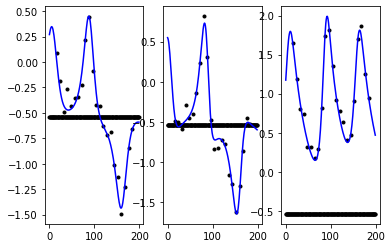

In [0]:
idx = 180

# Visualisation
plt.figure(1)
for jj in range(0,3):
  indjj = 131+jj
  plt.subplot(indjj)
  plt.plot(x_train_obs[idx,jj,:],'k.')
  plt.plot(x_train[idx,jj,:],'b-')

# PCA Decomposition & AE architecture

In [0]:
DimAE      = 20#50

In [0]:
# PCA decomposition
pca              = decomposition.PCA(DimAE)
pca.fit(np.reshape(x_train,(x_train.shape[0],x_train.shape[1]*x_train.shape[2])))

rec_PCA_Tt       = pca.transform(np.reshape(x_test,(x_test.shape[0],x_test.shape[1]*x_test.shape[2])))
rec_PCA_Tt[:,DimAE:] = 0.
rec_PCA_Tt       = pca.inverse_transform(rec_PCA_Tt)
mse_PCA_Tt       = np.mean( (rec_PCA_Tt - x_test.reshape((x_test.shape[0],x_test.shape[1]*x_test.shape[2])))**2 )
var_Tt           = np.mean( (x_test-np.mean(x_train,axis=0))** 2 )
exp_var_PCA_Tt   = 1. - mse_PCA_Tt / var_Tt

print(".......... PCA Dim = %d"%(DimAE))
print('.... explained variance PCA (Tr) : %.2f%%'%(100.*np.cumsum(pca.explained_variance_ratio_)[DimAE-1]))
print('.... explained variance PCA (Tt) : %.2f%%'%(100.*exp_var_PCA_Tt))

# visualize PCs and associated projection
PC              = np.zeros((DimAE+1,x_test.shape[1]*x_test.shape[2])) * float('NaN')                        
PC[1:DimAE+1,:] = pca.components_
PC[0,:]         = pca.mean_
PC              = np.reshape(PC,(DimAE+1,x_test.shape[1],x_test.shape[2]))

.......... PCA Dim = 20
.... explained variance PCA (Tr) : 96.19%
.... explained variance PCA (Tt) : 95.67%


In [0]:
print('........ Define AE architecture')
flagAEType = 0
shapeData  = x_train.shape[1:]
# freeze all ode parameters

if flagAEType == 0: ## AE using ode_L63

    class Encoder(torch.nn.Module):
        def __init__(self):
              super(Encoder, self).__init__()
              self.sigma = torch.nn.Parameter(torch.Tensor([np.random.randn()]))
              self.rho    = torch.nn.Parameter(torch.Tensor([np.random.randn()]))
              self.beta   = torch.nn.Parameter(torch.Tensor([np.random.randn()]))

              self.sigma  = torch.nn.Parameter(torch.Tensor([10.]))
              self.rho    = torch.nn.Parameter(torch.Tensor([28.]))
              self.beta   = torch.nn.Parameter(torch.Tensor([8./3.]))

              self.dt        = 0.01
              self.IntScheme = 1
              self.stdTr     = stdTr
              self.meanTr    = meanTr                      
        def _odeL63(self, xin):
            x1  = xin[:,0,:]
            x2  = xin[:,1,:]
            x3  = xin[:,2,:]
            
            dx_1 = (self.sigma*(x2-x1)).view(-1,1,xin.size(2))
            dx_2 = (x1*(self.rho-x3)-x2).view(-1,1,xin.size(2))
            dx_3 = (x1*x2 - self.beta*x3).view(-1,1,xin.size(2))
            
            dpred = torch.cat((dx_1,dx_2,dx_3),dim=1)
            return dpred

        def _EulerSolver(self, x):
            return x + self.dt * self._odeL63(x)

        def _RK4Solver(self, x):
            k1 = self._odeL63(x)
            x2 = x + 0.5 * self.dt * k1
            k2 = self._odeL63(x2)
          
            x3 = x + 0.5 * self.dt * k2
            k3 = self._odeL63(x3)
              
            x4 = x + self.dt * k3
            k4 = self._odeL63(x4)

            return x + self.dt * (k1+2.*k2+2.*k3+k4)/6.
      
        def forward(self, x):
            X = self.stdTr * x 
            X = X + self.meanTr
            
            if self.IntScheme == 0:
                xpred = self._EulerSolver( X[:,:,0:x.size(2)-1] )
            else:
                xpred = self._RK4Solver( X[:,:,0:x.size(2)-1] )

            xpred = xpred - self.meanTr
            xpred = xpred / self.stdTr

            xnew  = torch.cat((x[:,:,0].view(-1,x.size(1),1),xpred),dim=2)
            return xnew

    class Decoder(torch.nn.Module):
      def __init__(self):
          super(Decoder, self).__init__()

      def forward(self, x):
          return torch.mul(1.,x)
    
    genSuffixModel = '_DinAE4DVar'  
    modelTemp      = Encoder()
    if modelTemp.IntScheme == 0 :
        genSuffixModel = genSuffixModel+'_L63EulerNN'
    elif modelTemp.IntScheme == 1 :
        genSuffixModel = genSuffixModel+'_L63RK4NN'
        
elif flagAEType == 1: ## Conv model with no use of the central point
  dW = 1
  genSuffixModel = '_GENN1_%d_%02d_%02d'%(flagAEType,DimAE,dW)
  class Encoder(torch.nn.Module):
      def __init__(self):
          super(Encoder, self).__init__()
          self.conv1  = NN_4DVar.ConstrainedConv1d(shapeData[0],shapeData[0]*DimAE,2*dW+1,padding=dW,bias=False)
          #self.conv2  = torch.nn.Conv1d(5*shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          
          self.conv21 = torch.nn.Conv1d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          self.conv22 = torch.nn.Conv1d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          self.conv23 = torch.nn.Conv1d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          self.conv3  = torch.nn.Conv1d(2*shapeData[0]*DimAE,shapeData[0],1,padding=0,bias=False)
          #self.conv4 = torch.nn.Conv1d(4*shapeData[0]*DimAE,8*shapeData[0]*DimAE,1,padding=0,bias=False)

          #self.conv2Tr = torch.nn.ConvTranspose1d(4*shapeData[0]*DimAE,8*shapeData[0]*DimAE,4,stride=4,bias=False)          
          #self.conv5 = torch.nn.Conv1d(8*shapeData[0]*DimAE,16*shapeData[0]*DimAE,3,padding=1,bias=False)
          #self.conv6 = torch.nn.Conv1d(16*shapeData[0]*DimAE,shapeData[0],3,padding=1,bias=False)

      def forward(self, xinp):
          #x = self.fc1( torch.nn.Flatten(x) )
          #x = self.pool1( xinp )
          x = self.conv1( xinp )
          #x = self.conv2( F.relu(x) )
          x = torch.cat((self.conv21(x), self.conv22(x) * self.conv23(x)),dim=1)
          x = self.conv3( x )
          #x = self.conv4( F.relu(x) )
          x = x.view(-1,shapeData[0],shapeData[1])
          return x
  class Decoder(torch.nn.Module):
      def __init__(self):
          super(Decoder, self).__init__()

      def forward(self, x):
          return torch.mul(1.,x)

elif flagAEType == 2: ## Conv model with no use of the central point
  dW = 2
  genSuffixModel = '_GENN_%d_%02d_%02d'%(flagAEType,DimAE,dW)
  class Encoder(torch.nn.Module):
      def __init__(self):
          super(Encoder, self).__init__()
          self.pool1  = torch.nn.AvgPool1d(4)
          self.conv1  = NN_4DVar.ConstrainedConv1d(shapeData[0],shapeData[0]*DimAE,2*dW+1,padding=dW,bias=False)
          #self.conv2  = torch.nn.Conv1d(5*shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          
          self.conv21 = torch.nn.Conv1d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          self.conv22 = torch.nn.Conv1d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          self.conv23 = torch.nn.Conv1d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          self.conv3  = torch.nn.Conv1d(2*shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          #self.conv4 = torch.nn.Conv1d(4*shapeData[0]*DimAE,8*shapeData[0]*DimAE,1,padding=0,bias=False)

          self.conv2Tr = torch.nn.ConvTranspose1d(shapeData[0]*DimAE,shapeData[0],4,stride=4,bias=False)          
          #self.conv5 = torch.nn.Conv1d(8*shapeData[0]*DimAE,16*shapeData[0]*DimAE,3,padding=1,bias=False)
          #self.conv6 = torch.nn.Conv1d(16*shapeData[0]*DimAE,shapeData[0],3,padding=1,bias=False)

      def forward(self, xinp):
          #x = self.fc1( torch.nn.Flatten(x) )
          #x = self.pool1( xinp )
          x = self.pool1( xinp )
          x = self.conv1( x )
          #x = self.conv2( F.relu(x) )
          x = torch.cat((self.conv21(x), self.conv22(x) * self.conv23(x)),dim=1)
          x = self.conv3( x )
          x = self.conv2Tr( x )
          #x = self.conv4( F.relu(x) )
          x = x.view(-1,shapeData[0],shapeData[1])
          return x
  class Decoder(torch.nn.Module):
      def __init__(self):
          super(Decoder, self).__init__()

      def forward(self, x):
          return torch.mul(1.,x)
elif flagAEType == 3: ## Conv model with no use of the central point
  dW = 3
  genSuffixModel = '_GENNv2_%d_%02d_%02d'%(flagAEType,DimAE,dW)
  class Encoder(torch.nn.Module):
      def __init__(self):
          super(Encoder, self).__init__()
          self.pool1  = torch.nn.AvgPool1d(4)
          self.conv1  = NN_4DVar.ConstrainedConv1d(shapeData[0],2*shapeData[0]*DimAE,2*dW+1,padding=dW,bias=False)
          self.conv2  = torch.nn.Conv1d(2*shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          
          self.conv21 = torch.nn.Conv1d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          self.conv22 = torch.nn.Conv1d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          self.conv23 = torch.nn.Conv1d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          self.conv3  = torch.nn.Conv1d(2*shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          #self.conv4 = torch.nn.Conv1d(4*shapeData[0]*DimAE,8*shapeData[0]*DimAE,1,padding=0,bias=False)

          self.conv2Tr = torch.nn.ConvTranspose1d(shapeData[0]*DimAE,2*shapeData[0]*DimAE,4,stride=4,bias=False)          
          self.conv5 = torch.nn.Conv1d(2*shapeData[0]*DimAE,2*shapeData[0]*DimAE,3,padding=1,bias=False)
          self.conv6 = torch.nn.Conv1d(2*shapeData[0]*DimAE,shapeData[0],1,padding=0,bias=False)
          #self.conv6 = torch.nn.Conv1d(16*shapeData[0]*DimAE,shapeData[0],3,padding=1,bias=False)

      def forward(self, xinp):
          #x = self.fc1( torch.nn.Flatten(x) )
          #x = self.pool1( xinp )
          x = self.pool1( xinp )
          x = self.conv1( x )
          x = self.conv2( F.relu(x) )
          x = torch.cat((self.conv21(x), self.conv22(x) * self.conv23(x)),dim=1)
          x = self.conv3( x )
          x = self.conv2Tr( x )
          x = self.conv5( F.relu(x) )
          x = self.conv6( F.relu(x) )
          x = x.view(-1,shapeData[0],shapeData[1])
          return x
  class Decoder(torch.nn.Module):
      def __init__(self):
          super(Decoder, self).__init__()

      def forward(self, x):
          return torch.mul(1.,x)
elif flagAEType == 4: ## Conv model with no use of the central point
  dW = 5
  genSuffixModel = '_GENN_%d_%02d_%02d'%(flagAEType,DimAE,dW)
  class Encoder(torch.nn.Module):
      def __init__(self):
          super(Encoder, self).__init__()
          self.pool1  = torch.nn.AvgPool1d(4)
          self.conv1  = NN_4DVar.ConstrainedConv1d(shapeData[0],2*shapeData[0]*DimAE,2*dW+1,padding=dW,bias=False)
          self.conv2  = torch.nn.Conv1d(2*shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          
          self.conv21 = torch.nn.Conv1d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          self.conv22 = torch.nn.Conv1d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          self.conv23 = torch.nn.Conv1d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          self.conv3  = torch.nn.Conv1d(2*shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          #self.conv4 = torch.nn.Conv1d(4*shapeData[0]*DimAE,8*shapeData[0]*DimAE,1,padding=0,bias=False)

          self.conv2Tr = torch.nn.ConvTranspose1d(shapeData[0]*DimAE,shapeData[0],4,stride=4,bias=False)          
          #self.conv5 = torch.nn.Conv1d(2*shapeData[0]*DimAE,2*shapeData[0]*DimAE,3,padding=1,bias=False)
          #self.conv6 = torch.nn.Conv1d(2*shapeData[0]*DimAE,shapeData[0],1,padding=0,bias=False)
          #self.conv6 = torch.nn.Conv1d(16*shapeData[0]*DimAE,shapeData[0],3,padding=1,bias=False)

          self.convHR1  = NN_4DVar.ConstrainedConv1d(shapeData[0],2*shapeData[0]*DimAE,2*dW+1,padding=dW,bias=False)
          self.convHR1  = NN_4DVar.ConstrainedConv1d(shapeData[0],2*shapeData[0]*DimAE,2*dW+1,padding=dW,bias=False)
          self.convHR2  = torch.nn.Conv1d(2*shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          
          self.convHR21 = torch.nn.Conv1d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          self.convHR22 = torch.nn.Conv1d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          self.convHR23 = torch.nn.Conv1d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          self.convHR3  = torch.nn.Conv1d(2*shapeData[0]*DimAE,shapeData[0],1,padding=0,bias=False)

      def forward(self, xinp):
          #x = self.fc1( torch.nn.Flatten(x) )
          #x = self.pool1( xinp )
          x = self.pool1( xinp )
          x = self.conv1( x )
          x = self.conv2( F.relu(x) )
          x = torch.cat((self.conv21(x), self.conv22(x) * self.conv23(x)),dim=1)
          x = self.conv3( x )
          x = self.conv2Tr( x )
          #x = self.conv5( F.relu(x) )
          #x = self.conv6( F.relu(x) )
          
          xHR = self.convHR1( xinp )
          xHR = self.convHR2( F.relu(xHR) )
          xHR = torch.cat((self.convHR21(xHR), self.convHR22(xHR) * self.convHR23(xHR)),dim=1)
          xHR = self.convHR3( xHR )
          
          x   = torch.add(x,1.,xHR)
          
          x = x.view(-1,shapeData[0],shapeData[1])
          return x
  class Decoder(torch.nn.Module):
      def __init__(self):
          super(Decoder, self).__init__()

      def forward(self, x):
          return torch.mul(1.,x)

class Model_AE(torch.nn.Module):
    def __init__(self):
        super(Model_AE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder( x )
        x = self.decoder( x )
        return x

model_AE           = Model_AE()
print(' AE Model/Dynamical prior: '+genSuffixModel)
print(model_AE)
print('AE/Prior: Number of trainable parameters = %d'%(sum(p.numel() for p in model_AE.parameters() if p.requires_grad)))


........ Define AE architecture
 AE Model/Dynamical prior: _DinAE4DVar_L63RK4NN
Model_AE(
  (encoder): Encoder()
  (decoder): Decoder()
)
AE/Prior: Number of trainable parameters = 3


torch.Size([21, 3, 200])


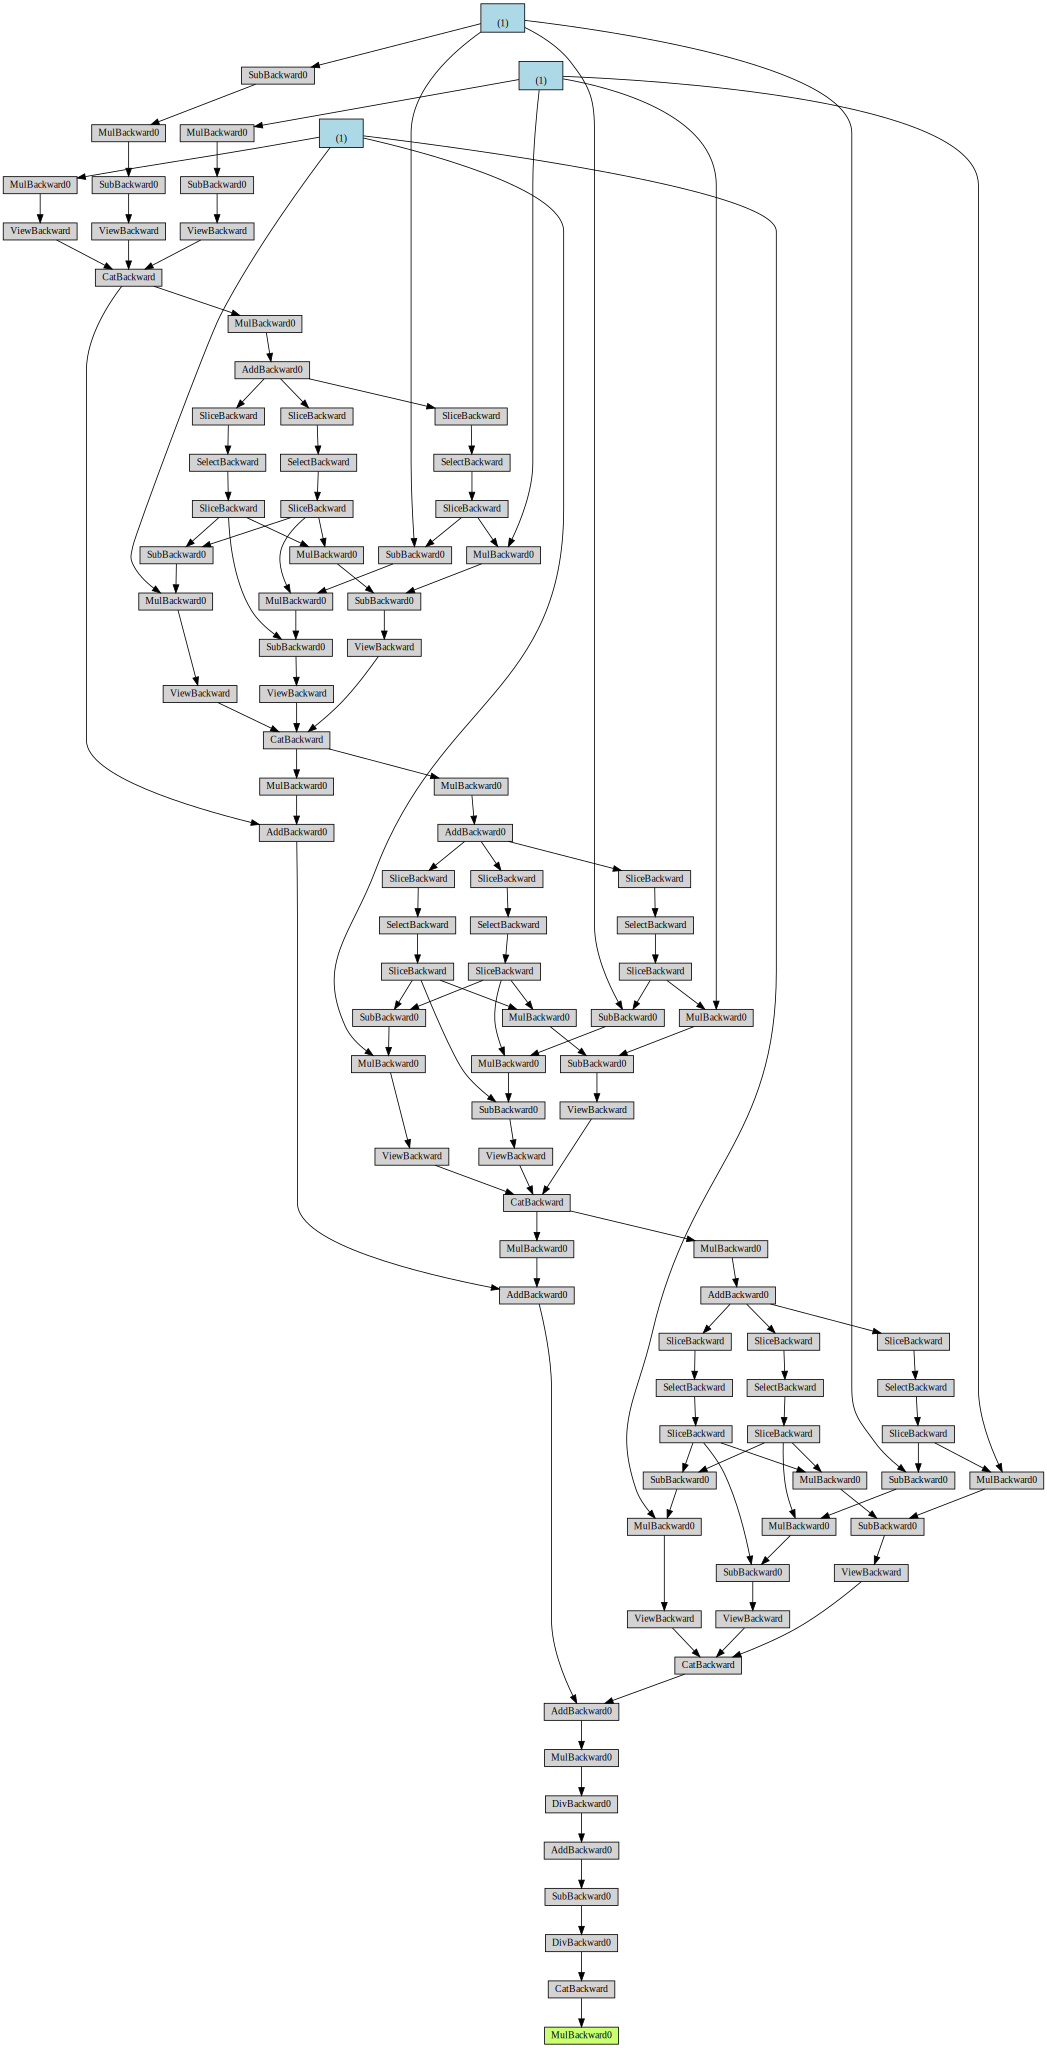

In [0]:
#Model visualisation
inputs = torch.randn(21,3,200)
y = model_AE(torch.autograd.Variable(inputs))
print(y.size())
torchviz.make_dot(y)

# Initial interpolation (linear interpolation)

In [0]:
# Initialization for interpolation
flagInit = 1

if flagInit == 0: 
  X_train_Init = mask_train * X_train_obs + (1. - mask_train) * (np.zeros(X_train_missing.shape) + meanTr)
  X_test_Init  = mask_test * X_test_obs + (1. - mask_test) * (np.zeros(X_test_missing.shape) + meanTr)
else:
  X_train_Init = np.zeros(X_train.shape)
  for ii in range(0,X_train.shape[0]):
    # Initial linear interpolation for each component
    XInit = np.zeros((X_train.shape[1],X_train.shape[2]))

    for kk in range(0,3):
      indt  = np.where( mask_train[ii,kk,:] == 1.0 )[0]
      indt_ = np.where( mask_train[ii,kk,:] == 0.0 )[0]

      if len(indt) > 1:
        indt_[ np.where( indt_ < np.min(indt)) ] = np.min(indt)
        indt_[ np.where( indt_ > np.max(indt)) ] = np.max(indt)
        fkk = scipy.interpolate.interp1d(indt, X_train_obs[ii,kk,indt])
        XInit[kk,indt]  = X_train_obs[ii,kk,indt]
        XInit[kk,indt_] = fkk(indt_)
      else:
        XInit = XInit + meanTr

    X_train_Init[ii,:,:] = XInit

  X_test_Init = np.zeros(X_test.shape)
  for ii in range(0,X_test.shape[0]):
    # Initial linear interpolation for each component
    XInit = np.zeros((X_test.shape[1],X_test.shape[2]))

    for kk in range(0,3):
      indt  = np.where( mask_test[ii,kk,:] == 1.0 )[0]
      indt_ = np.where( mask_test[ii,kk,:] == 0.0 )[0]

      if len(indt) > 1:
        indt_[ np.where( indt_ < np.min(indt)) ] = np.min(indt)
        indt_[ np.where( indt_ > np.max(indt)) ] = np.max(indt)
        fkk = scipy.interpolate.interp1d(indt, X_test_obs[ii,kk,indt])
        XInit[kk,indt]  = X_test_obs[ii,kk,indt]
        XInit[kk,indt_] = fkk(indt_)
      else:
        XInit = XInit + meanTr

    X_test_Init[ii,:,:] = XInit
      #plt.figure()
      #plt.figure()
      #plt.plot(YObs[0:200,1],'r.')
      #plt.plot(XGT[0:200,1],'b-')
      #plt.plot(XInit[0:200,1],'k-')


x_train_Init = ( X_train_Init - meanTr ) / stdTr
x_test_Init = ( X_test_Init - meanTr ) / stdTr


# Learning AE model

In [0]:
batch_size = 128

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AE           = model_AE.to(device)

# mean-squared error loss
#criterion = torch.nn.MSELoss()
var_Tr    = np.var( x_train )
var_Tt    = np.var( x_test )

#### Check AE performance 
optimizer_AE       = optim.Adam(model_AE.parameters(), lr=1e-3)
exp_lr_schedulerAE = lr_scheduler.StepLR(optimizer_AE, step_size=100, gamma=0.1)

training_dataset     = torch.utils.data.TensorDataset(torch.Tensor(x_train_missing),torch.Tensor(x_train_obs),torch.Tensor(mask_train),torch.Tensor(x_train)) # create your datset
test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_test_missing),torch.Tensor(x_test_obs),torch.Tensor(mask_test),torch.Tensor(x_test)) # create your datset

dataloaders = {
    'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
    'val': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
}

dataset_sizes = {'train': len(training_dataset), 'val': len(test_dataset)}


In [0]:
# training function for dinAE
since = time.time()

best_model_AE_wts = copy.deepcopy(model_AE.state_dict())
best_loss         = 1e10

num_epochs = 20
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
          model_AE.train()
        else:
          model_AE.eval()   # Set model to evaluate mode

        running_loss = 0.0
        num_loss     = 0

        # Iterate over data.
        #for inputs_ in dataloaders[phase]:
        #    inputs = inputs_[0].to(device)
        for inputs_init,inputs_missing,masks,targets_GT in dataloaders[phase]:
            targets_GT     = targets_GT.to(device)
            #print(inputs.size(0))

            # zero the parameter gradients
            optimizer_AE.zero_grad()

            # forward
            # need to evaluate grad/backward during the evaluation and training phase for model_AE
            with torch.set_grad_enabled(True): 
            #with torch.set_grad_enabled(phase == 'train'):
                outputs = model_AE(targets_GT)
                #outputs = model(inputs)
                #loss = criterion( outputs,  inputs)
                loss      = torch.mean((outputs - targets_GT)**2 )

                # backward + optimize only if in training phase
                if phase == 'train':
                  loss.backward()
                  optimizer_AE.step()

            # statistics
            running_loss             += loss.item() * inputs_missing.size(0)
            num_loss                 += inputs_missing.size(0)
            #running_expvar += torch.sum( (outputs - inputs)**2 ) / torch.sum(
        if phase == 'train':
            exp_lr_schedulerAE.step()

        epoch_loss       = running_loss / num_loss
        #epoch_acc = running_corrects.double() / dataset_sizes[phase]
        if phase == 'train':
          epoch_nloss = epoch_loss / var_Tr
        else:
          epoch_nloss = epoch_loss / var_Tt


        #print('{} Loss: {:.4f} '.format(
          #   phase, epoch_loss))
        print('{} Loss: {:.4e} NLossAll: {:.4e} '.format(
            phase, epoch_loss * stdTr**2,epoch_nloss))

        # deep copy the model
        if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model_AE.state_dict())

    print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val loss: {:4f}'.format(best_loss))

Epoch 0/19
----------
train Loss: 3.2259e-05 NLossAll: 1.7499e-07 
val Loss: 3.4472e-05 NLossAll: 1.7639e-07 

Epoch 1/19
----------
train Loss: 3.1663e-05 NLossAll: 1.7176e-07 
val Loss: 3.4500e-05 NLossAll: 1.7653e-07 

Epoch 2/19
----------
train Loss: 3.1662e-05 NLossAll: 1.7176e-07 
val Loss: 3.4482e-05 NLossAll: 1.7644e-07 

Epoch 3/19
----------
train Loss: 3.1663e-05 NLossAll: 1.7176e-07 
val Loss: 3.4486e-05 NLossAll: 1.7646e-07 

Epoch 4/19
----------
train Loss: 3.1663e-05 NLossAll: 1.7176e-07 
val Loss: 3.4480e-05 NLossAll: 1.7643e-07 

Epoch 5/19
----------
train Loss: 3.1662e-05 NLossAll: 1.7176e-07 
val Loss: 3.4476e-05 NLossAll: 1.7641e-07 

Epoch 6/19
----------
train Loss: 3.1663e-05 NLossAll: 1.7176e-07 
val Loss: 3.4475e-05 NLossAll: 1.7640e-07 

Epoch 7/19
----------
train Loss: 3.1663e-05 NLossAll: 1.7176e-07 
val Loss: 3.4476e-05 NLossAll: 1.7641e-07 

Epoch 8/19
----------
train Loss: 3.1662e-05 NLossAll: 1.7176e-07 
val Loss: 3.4473e-05 NLossAll: 1.7640e-07 

E

# Learning AE/4DVar model from irregularly-sampled data (DinAE solver vs. gradient-based solver) using a fully groundtruthed dataset

In [0]:
# Force observed values to be maintained to be kept to the
# initial values (noise-free case): InterpFlag = True 
# vs. noisy case InterpFlag = False (default parameter)
InterpFlag = False


#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# mean-squared error loss
#criterion = torch.nn.MSELoss()
var_Tr    = np.var( x_train )
var_Tt    = np.var( x_test )
              
alpha           = np.array([1.,0.1])
GradType        = 1 # Gradient computation (0: subgradient, 1: true gradient/autograd)
OptimType       = 2 # 0: fixed-step gradient descent, 1: ConvNet_step gradient descent, 2: LSTM-based descent


IterUpdate     = [0,100,200,300,500,3000]#[0,2,4,6,9,15]
NbProjection   = [0,0,0,0,0,0,0]#[0,0,0,0,0,0]#[5,5,5,5,5]##
NbGradIter     = [10,10,10,10,20]#[0,0,1,2,3,3]#[0,2,2,4,5,5]#
lrUpdate       = [1e-3,1e-3,1e-4,1e-5,1e-5,1e-5,1e-6,1e-6,1e-7]

#IterUpdate     = [0,200,400,600,1000,700]#[0,2,4,6,9,15]
#NbProjection   = [1,1,1,1,1,1,1]#[0,0,0,0,0,0]#[5,5,5,5,5]##
#NbGradIter     = [20,20,20,20,20]#[0,0,1,2,3,3]#[0,2,2,4,5,5]#
#lrUpdate       = [1e-3,1e-4,1e-5,1e-6,1e-5,1e-5,1e-6,1e-6,1e-7]

#NiterProjection = 1 # Number of fixed-point iterations
#NiterGrad       = 20 # Number of gradient descent step

# NiterProjection,NiterGrad: global variables
# bug for NiterProjection = 0
#model_AE_GradFP = Model_AE_GradFP(model_AE2,shapeData,NiterProjection,NiterGrad,GradType,OptimType)
NBGradCurrent   = NbGradIter[0]
NBProjCurrent   = NbProjection[0]
lrCurrent       = lrUpdate[0]
model           = NN_4DVar.Model_4DVarNN_GradFP(model_AE,shapeData,NBProjCurrent,NBGradCurrent,GradType,OptimType,InterpFlag)        
model           = model.to(device)
print('4DVar model: Number of trainable parameters = %d'%(sum(p.numel() for p in model.parameters() if p.requires_grad)))
                        
flagLoadModel   = 0
fileAEModelInit = '...' # TBD

if flagLoadModel == 1 :
    print('.... Load model: '+fileAEModelInit)
    model.model_AE.load_state_dict(torch.load(fileAEModelInit))
    model.model_Grad.load_state_dict(torch.load(fileAEModelInit.replace('_modelAE_iter','_modelGrad_iter')))

# optimization setting: freeze or not the AE
lambda_LRAE = 0.5
optimizer   = optim.Adam([{'params': model.model_Grad.parameters()},
                        {'params': model.model_AE.parameters(), 'lr': lambda_LRAE * lrCurrent}
                        ], lr=lrCurrent)

#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)            

x_train_Curr = np.copy(x_train_Init)
x_test_Curr  = np.copy(x_test_Init)

# Create training/test data pytorch tensors and associated  
# list of tensors (xx[n][x] to access the nth sample for the xth field)
training_dataset     = torch.utils.data.TensorDataset(torch.Tensor(x_train_Curr),torch.Tensor(x_train_obs),torch.Tensor(mask_train),torch.Tensor(x_train)) # create your datset
test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_test_Curr),torch.Tensor(x_test_obs),torch.Tensor(mask_test),torch.Tensor(x_test)) # create your datset

dataloaders = {
    'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
    'val': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
}            
dataset_sizes = {'train': len(training_dataset), 'val': len(test_dataset)}


# Suffix for file naming
genSuffixModelBase = genSuffixModel
genSuffixModel = genSuffixModelBase+'_DT'+str('%02d'%(time_step))+'_'+str('%03d'%(dT))
genSuffixModel = genSuffixModel+genSuffixObs

genSuffixModel = genSuffixModel+'_Nproj'+str('%02d'%(NBProjCurrent))
genSuffixModel = genSuffixModel+'_Grad_'+str('%02d'%(GradType))+'_'+str('%02d'%(OptimType))+'_'+str('%02d'%(NBGradCurrent))

# training function for dinAE
since = time.time()

alpha_Grad = alpha[0]
#alpha_FP   = 1. - alpha[0]
alpha_AE   = alpha[1]

best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 1e10


Opitm type 2
4DVar model: Number of trainable parameters = 3351


In [0]:
num_epochs  = 10
comptUpdate = 1
epoch_init  = 0
for epoch in range(epoch_init,num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    if ( epoch == IterUpdate[comptUpdate] ) & ( epoch > 0 ):
        # update GradFP parameters
        NBProjCurrent = NbProjection[comptUpdate]
        NBGradCurrent = NbGradIter[comptUpdate]
        lrCurrent     = lrUpdate[comptUpdate]
        
        #lrCurrent     = lrUpdate[comptUpdate]
        print("..... ")
        print("..... ")
        print("..... Update/initialize number of projections/Graditer in GradCOnvAE model # %d/%d"%(NbProjection[comptUpdate],NbGradIter[comptUpdate]))

        if( (NBProjCurrent != NbProjection[comptUpdate-1]) | (NBGradCurrent != NbGradIter[comptUpdate-1]) ):
            print("..... ")
            print("..... ")
            print("..... Update/initialize number of projections/Graditer in GradCOnvAE model # %d/%d"%(NbProjection[comptUpdate],NbGradIter[comptUpdate]))

            # update GradFP architectures
            print('..... Update model architecture')
            print("..... ")
            model = NN_4DVar.Model_4DVarNN_GradFP(model_AE,shapeData,NBProjCurrent,NBGradCurrent,GradType,OptimType,InterpFlag)        
            model = model.to(device)
            
            # copy model parameters from current model
            model.load_state_dict(best_model_wts)
            
            optimizer        = optim.Adam([{'params': model.model_Grad.parameters()},
                                    {'params': model.model_AE.encoder.parameters(), 'lr': lambda_LRAE*lrCurrent}
                                    ], lr=lrCurrent)

            # Suffix for file naming
            genSuffixModel = genSuffixModelBase+'_DT'+str('%02d'%(time_step))+'_'+str('%03d'%(dT))
            genSuffixModel = genSuffixModel+genSuffixObs
            if lambda_LRAE == 0. :
                  genSuffixModel = genSuffixModel+'_NoFTrAE'
            
            genSuffixModel = genSuffixModel+'_Nproj'+str('%02d'%(NBProjCurrent))
            genSuffixModel = genSuffixModel+'_Grad_'+str('%02d'%(GradType))+'_'+str('%02d'%(OptimType))+'_'+str('%02d'%(NBGradCurrent))

        else:
            # update optimizer learning rate
            print('..... Update learning rate')
            mm = 0
            lr = np.array([lrCurrent,lambda_LRAE*lrCurrent])
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr[mm]
                mm += 1

        # update counter
        if comptUpdate < len(IterUpdate)-1:
            comptUpdate += 1

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:        
        if phase == 'train':
            model.train()
        else:
            model.eval()
        #if phase == 'train':
        #    #rint('Learning')
        #    model.train()  # Set model to training mode
        #else:
        #    #print('Evaluation')
        #    model.eval()   # Set model to evaluate mode

        running_loss         = 0.0
        running_loss_All     = 0.
        running_loss_R       = 0.
        running_loss_I       = 0.
        running_loss_AE      = 0.
        num_loss     = 0

        # Iterate over data.
        #for inputs_ in dataloaders[phase]:
        #    inputs = inputs_[0].to(device)
        for inputs_init,inputs_missing,masks,targets_GT in dataloaders[phase]:
            inputs_init    = inputs_init.to(device)
            inputs_missing = inputs_missing.to(device)
            masks          = masks.to(device)
            targets_GT     = targets_GT.to(device)
            #print(inputs.size(0))

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # need to evaluate grad/backward during the evaluation and training phase for model_AE
            with torch.set_grad_enabled(True): 
            #with torch.set_grad_enabled(phase == 'train'):
                inputs_init    = torch.autograd.Variable(inputs_init, requires_grad=True)
                if model.OptimType == 1:
                    outputs,grad_new = model(inputs_init,inputs_missing,masks,None)
                    
                elif model.OptimType == 2:
                    outputs,hidden_new,cell_new = model(inputs_init,inputs_missing,masks,None,None)
                else:                               
                    outputs = model(inputs_init,inputs_missing,masks)
                
                loss_R      = torch.sum((outputs - targets_GT)**2 * masks )
                loss_R      = torch.mul(1.0 / torch.sum(masks),loss_R)
                loss_I      = torch.sum((outputs - targets_GT)**2 * (1. - masks) )
                loss_I      = torch.mul(1.0 / torch.sum(1.-masks),loss_I)
                loss_All    = torch.mean((outputs - targets_GT)**2 )
                loss_AE     = torch.mean((model.model_AE(outputs) - outputs)**2 )
                            
                loss_AE_GT  = torch.mean((model.model_AE(targets_GT) - targets_GT)**2 )

                loss  = alpha_Grad * loss_All + 0.5 * alpha_AE * ( loss_AE + loss_AE_GT )
            
                # backward + optimize only if in training phase
                if phase == 'train':
                  loss.backward()
                  optimizer.step()

            # statistics
            running_loss             += loss.item() * inputs_missing.size(0)
            running_loss_I           += loss_I.item() * inputs_missing.size(0)
            running_loss_R           += loss_R.item() * inputs_missing.size(0)
            running_loss_All         += loss_All.item() * inputs_missing.size(0)
            running_loss_AE          += loss_AE_GT.item() * inputs_missing.size(0)
            num_loss                 += inputs_missing.size(0)
        
        #if phase == 'train':
        #    exp_lr_scheduler.step()

        epoch_loss       = running_loss / num_loss
        epoch_loss_All   = running_loss_All / num_loss
        epoch_loss_AE    = running_loss_AE / num_loss
        epoch_loss_I     = running_loss_I / num_loss
        epoch_loss_R     = running_loss_R / num_loss            

        epoch_loss_All = epoch_loss_All * stdTr**2
        epoch_loss_I   = epoch_loss_I * stdTr**2
        epoch_loss_R   = epoch_loss_R * stdTr**2
        epoch_loss_AE  = epoch_loss_AE * stdTr**2

        #print('{} Loss: {:.4f} '.format(
          #   phase, epoch_loss))
        #print('{} Loss: {:.4e} NLossAll: {:.4e} NLossR: {:.4e} NLossI: {:.4e} NLossAE: {:.4e}'.format(
        #    phase, epoch_loss,epoch_nloss_All,epoch_nloss_R,epoch_nloss_I,epoch_loss_AE))
        print('{} Loss: {:.4e} NLossAll: {:.4e} NLossR: {:.4e} NLossI: {:.4e} NLossAE: {:.4e}'.format(
            phase, epoch_loss,epoch_loss_All,epoch_loss_R,epoch_loss_I,epoch_loss_AE))

        # deep copy the model
        if phase == 'val' and epoch_loss < best_loss:
            best_loss      = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val loss: {:4f}'.format(best_loss))

# load best model weights
model.load_state_dict(best_model_wts)


Epoch 0/9
----------
torch.Size([128, 15, 200])
torch.Size([128, 15, 200])
torch.Size([128, 15, 200])
torch.Size([128, 15, 200])
torch.Size([128, 15, 200])
torch.Size([128, 15, 200])
torch.Size([128, 15, 200])
torch.Size([128, 15, 200])
torch.Size([128, 15, 200])
torch.Size([128, 15, 200])


KeyboardInterrupt: ignored

# Learning AE/4DVar model to minimize the classic 4DVar variational cost

In [0]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(".... Device GPU: "+str(torch.cuda.is_available()))
#print(shapeData.shape)

# mean-squared error loss
#criterion = torch.nn.MSELoss()
var_Tr    = np.var( x_train )
var_Tt    = np.var( x_test )
              
alpha           = 1e0* np.array([.1,1.])
GradType        = 1 # Gradient computation (0: subgradient, 1: true gradient/autograd)
OptimType       = 2 # 0: fixed-step gradient descent, 1: ConvNet_step gradient descent, 2: LSTM-based descent

IterUpdate     = [0,200,600,1000,1200,1600]#[0,2,4,6,9,15]
#NbProjection   = [0,0,0,0,0,0,0]#[0,0,0,0,0,0]#[5,5,5,5,5]##
NbGradIter     = [10,10,10,10,10,10]#,10[0,0,1,2,3,3]#[0,2,2,4,5,5]#
lrUpdate       = [1e-3,1e-4,1e-3,1e-4,1e-4,1e-5,1e-6,1e-6,1e-7]

# NiterProjection,NiterGrad: global variables
# bug for NiterProjection = 0
#model_AE_GradFP = Model_AE_GradFP(model_AE2,shapeData,NiterProjection,NiterGrad,GradType,OptimType)
NBGradCurrent   = NbGradIter[0]
NBProjCurrent   = NbProjection[0]
lrCurrent       = lrUpdate[0]

if OptimType == -1:
    NBGradCurrent = 0
    NBProjCurrent = 0
    iterStateUpdate = 0
    
#model           = Model_AEL96_GradNoisyData2(model_AE,shapeData,NBProjCurrent,NBGradCurrent,GradType,OptimType)        
if OptimType >= 0:                
    #model = NN_4DVar.Model_4DVarNN_Grad(model_AE,shapeData,NBGradCurrent,GradType,OptimType,InterpFlag) 
    model = NN_4DVar.Model_4DVarNN_GradFP(model_AE,shapeData,0,NBGradCurrent,GradType,OptimType,InterpFlag)        
else:
    model           = NN_4DVar.Model_4DVarNN_Grad(model_AE,shapeData,NBGradCurrent,GradType,0,InterpFlag) 
    model.OptimType = -1
model           = model.to(device)
print('.... Optim Type: %d'%model.OptimType)
print('4DVar model: Number of trainable parameters = %d'%(sum(p.numel() for p in model.parameters() if p.requires_grad)))
  
flagLoadModel   = 0
fileAEModelInit = './ResL634DVar/l63_DinAE4DVar_L63EulerNN_DT01_200_ObsSub_87_20_Nproj01_Grad_01_02_20_modelAE_iter400.mod'
if flagLoadModel == 1:
    model.model_AE.load_state_dict(torch.load(fileAEModelInit))
    model.model_Grad.load_state_dict(torch.load(fileAEModelInit.replace('_modelAE_iter','_modelGrad_iter')))
genSuffixModelBase = genSuffixModel+'Flag9_'
        
#for param in model.model_Grad.parameters():
#   param.requires_grad = True

lambda_LRAE = 0.0
#optimizer_AE   = optim.Adam(model.model_AE.parameters(), lr=lambda_LRAE*lrCurrent)
#optimizer_Grad = optim.Adam(model.model_Grad.parameters(), lr=lrCurrent)

optimizer   = optim.Adam([{'params': model.model_Grad.parameters()},
                        {'params': model.model_AE.encoder.parameters(), 'lr': lambda_LRAE*lrCurrent}
                        ], lr=lrCurrent)

optimizer   = optim.RMSprop([{'params': model.model_Grad.parameters()},
                        {'params': model.model_AE.encoder.parameters(), 'lr': lambda_LRAE*lrCurrent}
                        ], lr=lrCurrent)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)            

#x_train_Curr = np.copy(x_train_Init)
#x_test_Curr  = np.copy(x_test_Init)

# Create training/test data pytorch tensors and associated  
# list of tensors (xx[n][x] to access the nth sample for the xth field)

x_Init  = x_test_Init
x_Curr  = torch.Tensor(np.copy( x_Init ))
#x_Curr  = torch.Tensor(np.random.randn(x_Init.shape[0],x_Init.shape[1],x_Init.shape[2]))

x_obs   = torch.Tensor(x_test_obs)
x_mask  = torch.Tensor(mask_test)
x_GT    = torch.Tensor(x_test)
if model.OptimType == 2:
    x_grad1 = torch.Tensor(np.random.randn(x_test.shape[0],model.model_Grad.DimState,x_test.shape[2]))
    x_grad2 = torch.Tensor(np.random.randn(x_test.shape[0],model.model_Grad.DimState,x_test.shape[2]))
else:
    x_grad1 = torch.Tensor(np.random.randn(x_test.shape[0],x_test.shape[2]))
    x_grad2 = torch.Tensor(np.random.randn(x_test.shape[0],x_test.shape[2]))
            
x_dataType = torch.Tensor(np.zeros((x_Curr.shape[0],1)))
x_idx      = torch.Tensor(np.arange(x_Curr.shape[0]))

x_dataset = torch.utils.data.TensorDataset(x_Curr,x_obs,x_mask,x_GT,x_dataType,x_idx,x_grad1,x_grad2) # create your datset

#training_dataset     = torch.utils.data.TensorDataset(torch.Tensor(x_train_Curr),torch.Tensor(x_train_obs),torch.Tensor(mask_train),torch.Tensor(x_train)) # create your datset
#test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_test_Curr),torch.Tensor(x_test_obs),torch.Tensor(mask_test),torch.Tensor(x_test)) # create your datset

dataloaders = {
    'dataset': torch.utils.data.DataLoader(x_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
}            
dataset_sizes = {'dataset': len(x_dataset)}

# Suffix for file naming
# training function for dinAE
since = time.time()

alpha_Grad = alpha[0]
#alpha_FP   = 1. - alpha[0]
alpha_AE   = alpha[1]

model.model_Grad.compute_Grad.alphaObs = torch.nn.Parameter(torch.Tensor([np.sqrt(alpha_Grad)]).to(device))
model.model_Grad.compute_Grad.alphaAE  = torch.nn.Parameter(torch.Tensor([np.sqrt(alpha_AE)]).to(device))

model.model_Grad.compute_Grad.alphaObs.requires_grad = False
model.model_Grad.compute_Grad.alphaAE.requires_grad  = False

best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 1e10

delta = torch.nn.Parameter(torch.Tensor([5.0e4]))
delta = delta.to(device)

.... Device GPU: True
Opitm type 2
.... Optim Type: 2
4DVar model: Number of trainable parameters = 3351


In [0]:
comptUpdate = 1
iterInit    = 0
iterStateUpdate = 250 
num_epochs      = 200 

for epoch in range(iterInit,num_epochs):
    #print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    #print('-' * 10)

    if ( model.OptimType >= 0 ) & ( epoch == IterUpdate[comptUpdate] ) & ( epoch > 0 ):
        # update GradFP parameters
        NBProjCurrent = NbProjection[comptUpdate]
        NBGradCurrent = NbGradIter[comptUpdate]
        lrCurrent     = lrUpdate[comptUpdate]
        
        print("..... ")
        print("..... ")
        print("..... Update/initialize number of projections/Graditer in GradCOnvAE model # %d/%d"%(NbProjection[comptUpdate],NbGradIter[comptUpdate]))

        # update GradFP architectures
        if( (NBProjCurrent != NbProjection[comptUpdate-1]) | (NBGradCurrent != NbGradIter[comptUpdate-1]) ):
            print('..... Update model architecture')
            print("..... ")
            model           = NN_4DVar.Model_4DVarNN_Grad(model_AE,shapeData,NBGradCurrent,GradType,OptimType,UsePriodicBoundary)        
            model           = model.to(device)
            
            # copy model parameters from current model
            model.load_state_dict(best_model_wts)
        
            # Suffix for file naming
            genSuffixModel = genSuffixModelBase+'_DT'+str('%02d'%(time_step))+'_'+str('%03d'%(dT))
            genSuffixModel = genSuffixModel+genSuffixObs
            if lambda_LRAE == 0. :
                  genSuffixModel = genSuffixModel+'_NoFTrAE'
            
            genSuffixModel = genSuffixModel+'_Nproj'+str('%02d'%(NBProjCurrent))
            genSuffixModel = genSuffixModel+'_Grad_'+str('%02d'%(GradType))+'_'+str('%02d'%(OptimType))+'_'+str('%02d'%(NBGradCurrent))

            optimizer   = optim.Adam([{'params': model.model_Grad.parameters()},
                                    {'params': model.model_AE.encoder.parameters(), 'lr': lambda_LRAE*lrCurrent}
                                    ], lr=lrCurrent)
    
            optimizer   = optim.RMSprop([{'params': model.model_Grad.parameters()},
                                    {'params': model.model_AE.encoder.parameters(), 'lr': lambda_LRAE*lrCurrent}
                                    ], lr=lrCurrent)
        else:
            # update optimizer learning rate
            print('..... Update learning rate')
            mm = 0
            lr = np.array([lrCurrent,lambda_LRAE*lrCurrent])
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr[mm]
                mm += 1

        # update counter
        if comptUpdate < len(IterUpdate)-1:
            comptUpdate += 1

    # Each epoch has a training and validation phase
    #for phase in ['val']:
    if 1*1:
        model.train()
        #if phase == 'train':
        #    #rint('Learning')
        #    model.train()  # Set model to training mode
        #else:
        #    #print('Evaluation')
        #    model.eval()   # Set model to evaluate mode

        running_loss         = 0.0
        running_loss_All     = 0.
        running_loss_R       = 0.
        running_loss_I       = 0.

        running_loss_AE      = 0.
        running_loss_AE_GT   = 0.
        num_loss             = 0

        # Iterate over data.
        #for inputs_ in dataloaders[phase]:
        #    inputs = inputs_[0].to(device)
        for inputs_init,inputs_missing,masks,targets_GT,dataType,idx,grad1,grad2 in dataloaders['dataset']:
            inputs_init    = inputs_init.to(device)
            inputs_missing = inputs_missing.to(device)
            masks          = masks.to(device)
            targets_GT     = targets_GT.to(device)
            dataType       = dataType.to(device)
                                     
            if model.OptimType == 1:
                grad_old = grad1.to(device)
            if model.OptimType == 2:
                hidden = grad1.to(device)
                cell   = grad2.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # need to evaluate grad/backward during the evaluation and training phase for model_AE
            with torch.set_grad_enabled(True): 
            #with torch.set_grad_enabled(phase == 'train'):
                inputs_init    = torch.autograd.Variable(inputs_init, requires_grad=True)
                
                if model.OptimType == 1:
                    grad_old          = torch.autograd.Variable(grad_old, requires_grad=True)
                    outputs,grad_new = model(inputs_init,inputs_missing,masks,grad_old)
                    
                elif model.OptimType == 2:
                    hidden          = torch.autograd.Variable(hidden, requires_grad=True)
                    cell            = torch.autograd.Variable(cell, requires_grad=True)
                    outputs,hidden_new,cell_new = model(inputs_init,inputs_missing,masks,hidden,cell)
                    
                else:                               
                    outputs = model(inputs_init,inputs_missing,masks)
                
                # minimized loss types
                dB          = 0
                dT          = outputs.size(2)
                loss_R      = torch.sum( (outputs[:,:,dB:dT-dB] - inputs_missing[:,:,dB:dT-dB])**2 * masks[:,:,dB:dT-dB] )
                loss_R      = loss_R / torch.sum( masks[:,:,dB:dT-dB] )
                loss_All    = torch.mean( (outputs[:,:,dB:dT-dB] - targets_GT[:,:,dB:dT-dB])**2 )                            
                loss_AE     = torch.mean( (model.model_AE(outputs)[:,:,dB:dT-dB] - outputs[:,:,dB:dT-dB])**2 )                                                        
                loss_AE_GT  = torch.mean( (model.model_AE(targets_GT)[:,:,dB:dT-dB] - targets_GT[:,:,dB:dT-dB])**2 )
                
                # loss dataType == 1 (data with known groudn-truth)
                loss        = alpha_Grad * loss_R + alpha_AE * loss_AE

                loss.backward(retain_graph=True)
                
                if model.OptimType >= 0 :
                    optimizer.step()
                    #print(model.model_Grad.gradNet1.weight)
                    #grad    = torch.autograd.grad(loss,x,create_graph=True)[0]
                    #grad.retain_grad()
                    #x     = x - delta * grad
                    
                    # copy the ouput in the input tensor for batch 
                    # after a few iterations
                    if( ( epoch >= iterStateUpdate ) & ( np.mod(epoch,10) == 0 ) ):
                        print('.... Update init state')
                        idx_batch = idx.detach().numpy().astype(int)
                          
                        UpdateInit = 1
                        if UpdateInit == 0:                                   
                            x     = inputs_init - delta * inputs_init.grad.data
                            x_Curr[idx_batch,:,:] = x.detach().clone().view(-1,outputs.size(2),outputs.size(3)).cpu()
                            
                            if model.OptimType == 1:
                                grad_old          = grad_old - delta * grad_old.grad.data                                    
                                x_grad1[idx_batch,:,:,:] = grad_old.detach().clone().cpu()
                            elif model.OptimType == 2:
                                hidden            = hidden - delta * hidden.grad.data
                                cell              = cell - delta * cell.grad.data
                                
                                x_grad1[idx_batch,:,:] = hidden.detach().clone().cpu()
                                x_grad2[idx_batch,:,:] = cell.detach().clone().cpu()
                        elif UpdateInit == 1:                                   
                            beta = 1.0
                            x     = (1.-beta) * inputs_init + beta * outputs
                            x_Curr[idx_batch,:,:] = x.detach().clone().view(-1,outputs.size(2),outputs.size(3)).cpu()
                            
                            if model.OptimType == 1:
                                grad_old          = (1.-beta) * grad_old + beta * grad_new                                   
                                x_grad1[idx_batch,:,:,:] = grad_old.detach().clone().cpu()
                            elif model.OptimType == 2:
                                hidden            = (1.-beta) * hidden + beta * hidden_new                                   
                                cell              = (1.-beta) * hidden + beta * cell_new                                   
                                
                                x_grad1[idx_batch,:,:] = hidden.detach().clone().cpu()
                                x_grad2[idx_batch,:,:] = cell.detach().clone().cpu()
                else :
                    idx_batch = idx.detach().numpy().astype(int)
                    x     = inputs_init -  delta * inputs_init.grad.data 
                    x_Curr[idx_batch,:,:] = x.detach().clone().view(-1,outputs.size(2),outputs.size(3)).cpu()
                                                  
                # other losses
                loss_I      = torch.sum( (outputs[:,:,dB:dT-dB] - targets_GT[:,:,dB:dT-dB])**2 * (1. - masks[:,:,dB:dT-dB]) )
                loss_I      = loss_I / torch.sum( (1. - masks[:,:,dB:dT-dB]) )
                    
            # statistics            
            running_loss             += loss.item() * inputs_missing.size(0)
            running_loss_I           += loss_I.item() * inputs_missing.size(0)
            running_loss_R           += loss_R.item() * inputs_missing.size(0)
            running_loss_All         += loss_All.item() * inputs_missing.size(0)
            running_loss_AE          += loss_AE.item() * inputs_missing.size(0)
            running_loss_AE_GT       += loss_AE_GT.item() * inputs_missing.size(0)
            num_loss                 += inputs_missing.size(0)
            #running_expvar += torch.sum( (outputs - inputs)**2 ) / torch.sum(
        #if phase == 'train':
        #    exp_lr_scheduler.step()

        epoch_loss        = running_loss / (num_loss)
        epoch_loss_All    = running_loss_All / num_loss
        epoch_loss_AE     = running_loss_AE / num_loss
        epoch_loss_AE_GT  = running_loss_AE_GT / num_loss
        epoch_loss_I      = running_loss_I / num_loss                                        
        epoch_loss_R      = running_loss_R / num_loss
        
        #epoch_acc = running_corrects.double() / dataset_sizes[phase]

        epoch_loss     = epoch_loss * stdTr**2
        epoch_loss_All = epoch_loss_All * stdTr**2
        epoch_loss_I   = epoch_loss_I * stdTr**2
        epoch_loss_R   = epoch_loss_R * stdTr**2
        epoch_loss_AE  = epoch_loss_AE * stdTr**2
        epoch_loss_AE_GT  = epoch_loss_AE_GT * stdTr**2

        print('.... Epoch %d/%d: Total loss %.4e [Obs data] NLossAll: %.4e NLossR: %.4e NLossI: %.4e NLossAE: %.4e NLossAEGT: %.4e'%(epoch, num_epochs - 1,epoch_loss,epoch_loss_All,epoch_loss_R,epoch_loss_I,epoch_loss_AE,epoch_loss_AE_GT),flush=True)

        # update dataset in dataloader
        x_dataset = torch.utils.data.TensorDataset(x_Curr,x_obs,x_mask,x_GT,x_dataType,x_idx,x_grad1,x_grad2) # create your datset
        dataloaders = {
                'dataset': torch.utils.data.DataLoader(x_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
                }            
        # deep copy the model
        if epoch_loss < best_loss:
            best_loss      = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))


.... Epoch 0/199: Total loss 1.3136e+01 [Obs data] NLossAll: 5.3045e+01 NLossR: 9.4100e+00 NLossI: 5.8267e+01 NLossAE: 1.2195e+01 NLossAEGT: 1.3780e-03
.... Epoch 1/199: Total loss 1.6821e+00 [Obs data] NLossAll: 3.9995e+01 NLossR: 2.5372e+00 NLossI: 4.4459e+01 NLossAE: 1.4284e+00 NLossAEGT: 1.3780e-03
.... Epoch 2/199: Total loss 1.2327e+00 [Obs data] NLossAll: 3.7693e+01 NLossR: 1.9839e+00 NLossI: 4.1945e+01 NLossAE: 1.0344e+00 NLossAEGT: 1.3780e-03
.... Epoch 3/199: Total loss 1.0288e+00 [Obs data] NLossAll: 3.6559e+01 NLossR: 1.7381e+00 NLossI: 4.0704e+01 NLossAE: 8.5502e-01 NLossAEGT: 1.3780e-03
.... Epoch 4/199: Total loss 9.0382e-01 [Obs data] NLossAll: 3.5803e+01 NLossR: 1.5867e+00 NLossI: 3.9875e+01 NLossAE: 7.4515e-01 NLossAEGT: 1.3780e-03
.... Epoch 5/199: Total loss 8.1512e-01 [Obs data] NLossAll: 3.5218e+01 NLossR: 1.4734e+00 NLossI: 3.9233e+01 NLossAE: 6.6778e-01 NLossAEGT: 1.3780e-03
.... Epoch 6/199: Total loss 7.4679e-01 [Obs data] NLossAll: 3.4710e+01 NLossR: 1.3830e+

KeyboardInterrupt: ignored

# Evaluation of trained models

In [0]:
alpha4DVar = np.array([0.1,1.])  

# Create training/test data pytorch tensors and associated  
# list of tensors (xx[n][x] to access the nth sample for the xth field)
training_dataset     = torch.utils.data.TensorDataset(torch.Tensor(x_train_Init),torch.Tensor(x_train_obs),torch.Tensor(mask_train),torch.Tensor(x_train)) # create your datset
test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_test_Init),torch.Tensor(x_test_obs),torch.Tensor(mask_test),torch.Tensor(x_test)) # create your datset

dataloaders = {
    'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True),
    'val': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True),
}            
dataset_sizes = {'train': len(training_dataset), 'val': len(test_dataset)}

# training function for dinAE
# Each epoch has a training and validation phase
y_train = np.zeros(x_train.shape)
y_test  = np.zeros(x_test.shape)

for phase in ['train', 'val']:        
    since = time.time()

    model.eval()
    #if phase == 'train':
    #    #rint('Learning')
    #    model.train()  # Set model to training mode
    #else:
    #    #print('Evaluation')
    #    model.eval()   # Set model to evaluate mode

    running_loss_Obs     = 0.0
    running_loss_All     = 0.
    running_loss_R       = 0.
    running_loss_I       = 0.
    running_loss_AE      = 0.
    running_loss_AE_GT   = 0.
    num_loss             = 0

    idx = 0 # counter

    # Iterate over data.
    #for inputs_ in dataloaders[phase]:
    #    inputs = inputs_[0].to(device)
    for inputs_init,inputs_missing,masks,targets_GT in dataloaders[phase]:
        inputs_init    = inputs_init.to(device)
        inputs_missing = inputs_missing.to(device)
        masks          = masks.to(device)
        targets_GT     = targets_GT.to(device)
        #print(inputs_init.size(0))

        # forward
        # need to evaluate grad/backward during the evaluation and training phase for model_AE
        with torch.set_grad_enabled(True): 
            #with torch.set_grad_enabled(phase == 'train'):
            inputs_init    = torch.autograd.Variable(inputs_init, requires_grad=True)
            if model.OptimType == 1:
                outputs,grad_new = model(inputs_init,inputs_missing,masks,None)
                
            elif model.OptimType == 2:
                outputs,hidden_new,cell_new = model(inputs_init,inputs_missing,masks,None,None)
                
            else:                               
                outputs = model(inputs_init,inputs_missing,masks)

            #outputs = model(inputs_init,inputs_missing,masks)
            
            # compute evaluation metrics
            loss_R      = torch.sum((outputs - targets_GT)**2 * masks ) / torch.sum(masks)
            loss_Obs    = torch.sum((outputs - inputs_missing)**2 * masks ) / torch.sum(masks)
            loss_I      = torch.sum((outputs - targets_GT)**2 * (1. - masks) ) / torch.sum(1.-masks)
            loss_All    = torch.mean((outputs - targets_GT)**2 )
            loss_AE     = torch.mean((model.model_AE(outputs) - outputs)**2 )

            loss_AE_GT  = torch.mean((model.model_AE(targets_GT) - targets_GT)**2 )
                            
            # store interpolation/reconstruction results
            if phase == 'train':
              y_train[idx:idx+inputs_missing.size(0),:,:] = outputs.cpu().detach().numpy()
            else:
              y_test[idx:idx+inputs_missing.size(0),:,:]  = outputs.cpu().detach().numpy()

            idx += inputs_missing.size(0)

        # statistics
        running_loss_I           += loss_I.item() * inputs_missing.size(0)
        running_loss_R           += loss_R.item() * inputs_missing.size(0)
        running_loss_Obs         += loss_Obs.item() * inputs_missing.size(0)
        running_loss_All         += loss_All.item() * inputs_missing.size(0)
        running_loss_AE_GT       += loss_AE_GT.item() * inputs_missing.size(0)
        running_loss_AE          += loss_AE.item() * inputs_missing.size(0)
        num_loss                 += inputs_missing.size(0)

    epoch_loss_All   = running_loss_All / num_loss
    epoch_loss_AE    = running_loss_AE / num_loss
    epoch_loss_AE_GT = running_loss_AE_GT / num_loss
    epoch_loss_I     = running_loss_I / num_loss
    epoch_loss_R     = running_loss_R / num_loss
    epoch_loss_Obs   = running_loss_Obs / num_loss

    epoch_loss_All   = epoch_loss_All * stdTr**2
    epoch_loss_I     = epoch_loss_I * stdTr**2
    epoch_loss_R     = epoch_loss_R * stdTr**2
    epoch_loss_Obs   = epoch_loss_Obs * stdTr**2
    epoch_loss_AE    = epoch_loss_AE * stdTr**2
    epoch_loss_AE_GT = epoch_loss_AE_GT * stdTr**2
    epoch_loss_4DVar = alpha4DVar[0] * epoch_loss_Obs + alpha4DVar[1] * epoch_loss_AE

    print('{} Loss4DVar: {:.4e} NLossObsGT: {:.4e} NLossObsNoisy {:.4e} NLossR: {:.4e} NLossI: {:.4e} NLossAE: {:.4e} NLossAEGT: {:.4e}'.format(
        phase, epoch_loss_4DVar,epoch_loss_All,epoch_loss_Obs,epoch_loss_R,epoch_loss_I,epoch_loss_AE,epoch_loss_AE_GT),flush=True)
        #print('... F %f'%model.model_AE.encoder.F)

    time_elapsed = time.time() - since
    print('Eval. time in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))


train Loss4DVar: 2.2842e-01 NLossObsGT: 8.6253e-01 NLossObsNoisy 1.0437e+00 NLossR: 4.9966e-01 NLossI: 9.0738e-01 NLossAE: 1.2405e-01 NLossAEGT: 1.3371e-03
Eval. time in 0m 6s
val Loss4DVar: 2.3327e-01 NLossObsGT: 8.9304e-01 NLossObsNoisy 1.0496e+00 NLossR: 4.9965e-01 NLossI: 9.4167e-01 NLossAE: 1.2831e-01 NLossAEGT: 1.4137e-03
Eval. time in 0m 1s


... Example from the training dataset: MSE =0.0018 
... Example from the test dataset: MSE =0.0035 


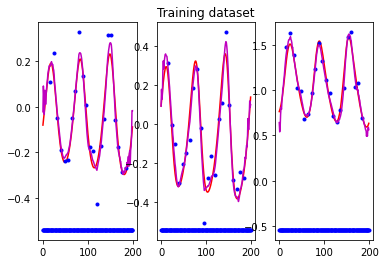

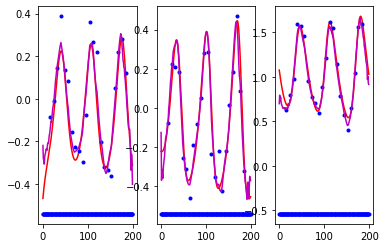

In [0]:
## Visualisation
idxTr = np.random.permutation(y_train.shape[0])[0:2]
idxTt = np.random.permutation(y_test.shape[0])[0:2]

plt.figure(1)
for kk in range(0,3):
  plt.subplot(1,3,kk+1)
  if kk == 1:
    plt.title('Training dataset')
  plt.plot(x_train[idxTr[0],kk,:],'r-')
  plt.plot(x_train_obs[idxTr[0],kk,:],'b.')
  plt.plot(y_train[idxTr[0],kk,:],'m-')
print('... Example from the training dataset: MSE =%.4f '%np.mean( (x_train[idxTr[0],:,:]-y_train[idxTr[0],:,:])**2 ),flush=True)

plt.figure(2)
for kk in range(0,3):
  plt.subplot(1,3,kk+1)
  plt.plot(x_test[idxTt[0],kk,:],'r-')
  plt.plot(x_test_obs[idxTt[0],kk,:],'b.')
  plt.plot(y_test[idxTt[0],kk,:],'m-')
print('... Example from the test dataset: MSE =%.4f '%np.mean( (x_test[idxTt[0],:,:]-y_test[idxTt[0],:,:])**2 ),flush=True)



# 4DVar Assimilsation in pytorch

In [0]:
test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_test_Init),torch.Tensor(x_test_obs),torch.Tensor(mask_test),torch.Tensor(x_test)) # create your datset

dataloaders = {
    'dataset': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
}            
dataset_sizes = {'dataset': len(test_dataset)}

In [0]:
comptUpdate = 1
iterInit    = 0
iterStateUpdate = 250 
NIterGrad       = 10000
modIter         = 100
delta           = 1e4 
alpha           = 1e0* np.array([.01,0.99])

# Iterate over data.
#for inputs_ in dataloaders[phase]:
#    inputs = inputs_[0].to(device)

numData  = 0
compt    = 0
for x_init,x_obs,masks,x_GT in dataloaders['dataset']:
    x_init    = x_init.to(device)
    x_obs     = x_obs.to(device)
    masks     = masks.to(device)
    x_GT      = x_GT.to(device)

    numData +=  x_GT.size(0)

    # initialisation
    xhat = x_init 
    xhat = torch.autograd.Variable(xhat, requires_grad=True)

    # 4DVar assimilation using trained gradient descent
    losses_test = []
    compt_kk = 0
    for kk in range(0,NIterGrad):     
        # AE projection
        x_pred = model.model_AE( xhat )
        
        # dynamical loss
        loss_dyn = torch.mean((xhat - x_pred)**2 )
    
        # observation loss
        loss_obs = torch.sum((xhat - x_obs)**2 * masks) / torch.sum( masks)
    
        ## loss wrt groudn-truth
        loss_GT  = torch.mean((xhat - x_GT)**2)

        # overall loss
        loss = alpha[0] * loss_obs + alpha[1] * loss_dyn 
    
        # compute gradient w.r.t. X and update X
        loss.backward()
        
        #grad_X  = torch.autograd.grad(loss,X_torch,create_graph=True)
        xhat = xhat - delta * xhat.grad.data
        xhat = torch.autograd.Variable(xhat, requires_grad=True)
                                                          
        # other loss types
        dB          = 0
        dT          = xhat.size(2)
        loss_R      = torch.sum( (xhat[:,:,dB:dT-dB] - x_GT[:,:,dB:dT-dB])**2 * masks[:,:,dB:dT-dB] )
        loss_R      = loss_R / torch.sum( masks[:,:,dB:dT-dB] )
        loss_AE_GT  = torch.mean( (model.model_AE(x_GT)[:,:,dB:dT-dB] - x_GT[:,:,dB:dT-dB])**2 )        
        loss_I      = torch.sum( (xhat[:,:,dB:dT-dB] - x_GT[:,:,dB:dT-dB])**2 * (1. - masks[:,:,dB:dT-dB]) )
        loss_I      = loss_I / torch.sum( (1. - masks[:,:,dB:dT-dB]) )

        # evaluate and store losses
        if( np.mod(kk,modIter) == 0 ):  
            # store as np
            if( compt_kk == 0 ):
                losses_test = torch.cat( (loss_GT.view(1,1),loss_dyn.view(1,1),loss_obs.view(1,1),loss_R.view(1,1),loss_I.view(1,1)), dim = 1 ).cpu().detach().numpy()                                
            else:
                losses_test = np.concatenate( (losses_test,torch.cat( (loss_GT.view(1,1),loss_dyn.view(1,1),loss_obs.view(1,1),loss_R.view(1,1),loss_I.view(1,1)), dim = 1 ).cpu().detach().numpy()) , axis = 0)
            compt_kk += 1
    if compt == 0 :
        loss4DVar = x_GT.size(0) * losses_test
    else :
        loss4DVar = loss4DVar + x_GT.size(0) * losses_test
    compt += 1
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

loss4DVar = stdTr**2 * loss4DVar / numData
                            
print('..........................................')
print('.....')
print('.....')
print('')
for kk in range(0,loss4DVar.shape[0]):
    print('..... Loss Grad Descent %d:  GT %.6e   ---  dyn %.6e   ---  obs %.6e   ---  GT-R %.6e    ---  GT-I %.6e'%(kk*modIter,loss4DVar[kk,0],loss4DVar[kk,1],loss4DVar[kk,2],loss4DVar[kk,3],loss4DVar[kk,4]) )


Training complete in 114m 51s
..........................................
.....
.....

..... Loss Grad Descent 0:  GT 4.155239e+01   ---  dyn 2.700611e+00   ---  obs 0.000000e+00   ---  GT-R 3.356676e+00    ---  GT-I 4.509390e+01
..... Loss Grad Descent 100:  GT 2.909852e+01   ---  dyn 9.960453e-02   ---  obs 4.550298e+00   ---  GT-R 4.239138e+00    ---  GT-I 3.209847e+01
..... Loss Grad Descent 200:  GT 2.375221e+01   ---  dyn 6.442648e-02   ---  obs 4.331579e+00   ---  GT-R 3.791926e+00    ---  GT-I 2.616885e+01
..... Loss Grad Descent 300:  GT 1.984228e+01   ---  dyn 4.716914e-02   ---  obs 3.954605e+00   ---  GT-R 3.346941e+00    ---  GT-I 2.184273e+01
..... Loss Grad Descent 400:  GT 1.681023e+01   ---  dyn 3.668356e-02   ---  obs 3.551134e+00   ---  GT-R 2.920178e+00    ---  GT-I 1.849675e+01
..... Loss Grad Descent 500:  GT 1.439049e+01   ---  dyn 2.964296e-02   ---  obs 3.174649e+00   ---  GT-R 2.536306e+00    ---  GT-I 1.583124e+01
..... Loss Grad Descent 600:  GT 1.242442e+01 